In [1]:
from foundry.util.registry import Registry
import foundry.core.tree as tree
import foundry.core as F
import foundry.datasets.vision
import foundry.numpy as npx

registry = Registry()
foundry.datasets.vision.register_all(registry)
dataset = registry.create("mnist")

normalizer = dataset.normalizer("hypercube")
train_data = dataset.split("train")
train_data = F.vmap(normalizer.normalize)(train_data.as_pytree())
train_data = tree.map(lambda x: x[:10*2048], train_data)

In [2]:
import numpy as np
import jax

def Hbeta(D=np.array([]), beta=1.0):
    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:
            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP
    # Return final P-matrix
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    # X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.array(jax.random.normal(jax.random.key(42), (n, no_dims)))
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    # P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        if iter == 0:
            print("P[0]:", P[0,:])
            print("Q[0]: ", Q[1,:])
            C = P * np.log(P / Q)
            print("Error: ", C[0])
            C = np.sum(C)
            print("Initial error is %f" % (C))

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0 or iter == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

    # Return solution
    return Y


if __name__ == "__main__":
    print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
    print("Running example on 2,500 MNIST digits...")
    X = train_data.pixels.reshape((-1, 28*28))[:1024]
    labels = train_data.label[:1024]
    Y = tsne(X, 2, 50, 30.0)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 MNIST digits...
Computing pairwise distances...
Computing P-values for point 0 of 1024...
Computing P-values for point 500 of 1024...
Computing P-values for point 1000 of 1024...
P[0]: [1.00000000e-12 1.66066565e-07 3.59516390e-10 ... 1.82067127e-06
 1.60452490e-07 4.35463637e-09]
Q[0]:  [4.5265088e-07 1.0000000e-12 1.5973784e-07 ... 2.0849923e-06 2.7693926e-07
 7.2341697e-07]
Error:  [ 3.99580279e-21 -1.66520332e-07 -2.55575608e-09 ...  1.83692702e-06
 -2.44373414e-07 -2.68340279e-08]
Initial error is 3.586371
Iteration 1: error is 3.586371
Iteration 10: error is 2.903387
Iteration 20: error is 2.110164
Iteration 30: error is 1.600495
Iteration 40: error is 1.379029
Iteration 50: error is 1.278536
Iteration 60: error is 1.216730
Iteration 70: error is 1.172775
Iteration 80: error is 1.142007
Iteration 90: error is 1.118424
Iteration 100: error is 1.098729
Iteration 110: error is 1.0824

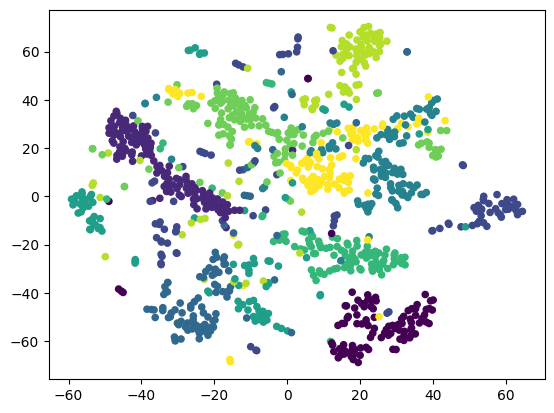

In [3]:
import matplotlib.pyplot as plt
plt.scatter(Y[:, 0], Y[:, 1], 20, labels)
plt.show()